In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import os
import glob
import datetime
import matplotlib.pyplot as plt
from functions import preproc_nemo
from functions import dateDecimal
from functions import interp_average
from functions import moving_average

# simulation name and path
expname='beta'
expdir=os.path.join('/ec/res4/scratch/itas/ece4/', expname, 'output', 'nemo')

# compute weights for the integrals
domain = xr.open_dataset(os.path.join(expdir, '..', '..', 'domain_cfg.nc'))
vol = domain['e1t']*domain['e2t']*domain['e3t_0']
area = domain['e1t']*domain['e2t']
sect = domain['e2t']*domain['e3t_0']
dz = domain['e3t_0']

# load dataset
start_year = 1990
end_year = 2000
filelist = []
for year in range(start_year, end_year + 1):
    pattern = os.path.join(expdir, f"{expname}_oce_1m_T_{year}-{year}.nc")
    matching_files = glob.glob(pattern)
    filelist.extend(matching_files)
data = xr.open_mfdataset(filelist, preprocess=preproc_nemo)

In [2]:
data.coords['z'] = -data['z']

In [3]:
data

<xarray.Dataset>
Dimensions:               (y: 331, x: 360, time: 132, z: 75, axis_nbounds: 2)
Coordinates:
    nav_lat_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon_grid_T        (y, x) float32 dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1990-01-16T12:00:00 ... 2000-...
  * z                     (z) float32 -0.5 -1.55 ... -5.698e+03 -5.902e+03
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/25)
    deptht_bounds         (time, z, axis_nbounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    e3t                   (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    thetao                (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    so                    (time, z, y, x) float32 dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
    ...                    ...
    qt_oce                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    sfx                   (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    taum                  (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    windsp                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    precip                (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    snowpre               (time, y, x) float32 dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    name:         output/nemo/beta_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2023-Oct-20 14:50:50 GMT
    uuid:         41f17b0e-e220-4e91-b7ec-69f660c4d6e0

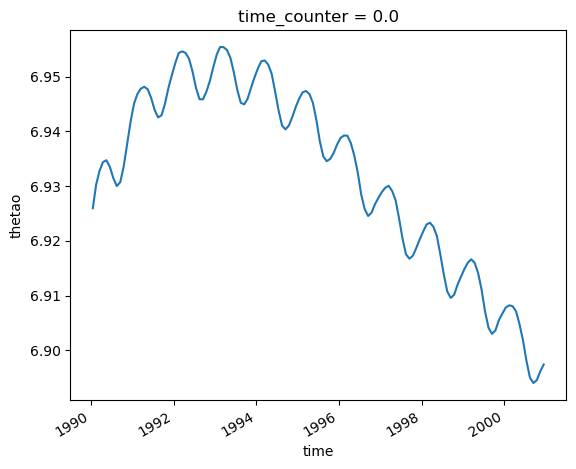

In [4]:
data.thetao.weighted(vol).mean(dim=['z', 'y', 'x']).plot()

In [5]:
sstz = data.isel(z=slice(0,23)).thetao
volz = vol.isel(z=slice(0,23))

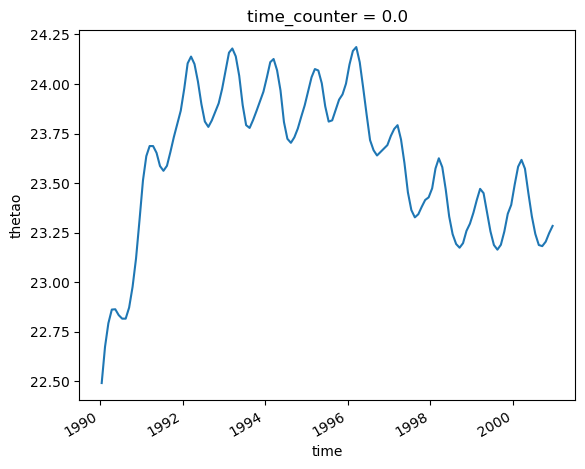

: 

In [8]:
data['thetao'].isel(z=slice(0,23)).weighted(vol.isel(z=slice(0,23))).mean(dim=['z', 'y', 'x']).plot()


In [ ]:
# dictionaries for mean quantities
avews = {}  # with seasons - original
avens = {}  # no seasons - moving averaged
fieldnames = []

avews['timeg'] = data['time'].values
avens['timeg'] = data['time'].values
timef = len(data['time'].values)
fieldnames.append('timeg')

# 3d fields
for field in ['thetao', 'so']:
    avews[f'{field}g'] = data[f'{field}'].weighted(vol).mean(dim=['z', 'y', 'x'])
    avews[f'{field}m'] = data[f'{field}'].isel(z=slice(0,23)).weighted(vol).mean(dim=['z', 'y', 'x'])
    avews[f'{field}p'] = data[f'{field}'].isel(z=slice(24,45)).weighted(vol).mean(dim=['z', 'y', 'x'])
    avews[f'{field}b'] = data[f'{field}'].isel(z=slice(46,74)).weighted(vol).mean(dim=['z', 'y', 'x'])
    fieldnames.append(f'{field}g')
    fieldnames.append(f'{field}m')
    fieldnames.append(f'{field}p')
    fieldnames.append(f'{field}b')

# 2d fields
for field in ['tos', 'sos', 'heatc', 'saltc', 'qsr_oce', 'qns_oce', 'qt_oce', 'sfx', 'wfo']:
    avews[f'{field}g'] = data[f'{field}'].weighted(area).mean(dim=['y', 'x']).values.flatten()
    fieldnames.append(f'{field}g')

######
# compute averages without seasonal cycle using moving average
for field in fieldnames[1:]:
    avens[f'{field}'] = moving_average(avews[f'{field}'], 12)

In [ ]:
# write output on ascii file
for kind in ['ws', 'ns']:
    with open(f'ave_{kind}.dat', 'w') as file:
        print('# time(1) to(2) so(3) tom(4) top(5) tob(6) som(7) sop(8) sob(9)', file=file)
        print('# tos(10) sos(11) heatc(12) saltc(13) qsr(14) qns(15) qt(16) sfx(17) wfo(18) ', file=file)
        print('# ', file=file)
        for i in range(timef-1):
            row = [f"{ave{kind}[{field}][i]:<5}" for field in fieldnames]
            print(" ".join(row), file=file)